El objetivo de la siguiente prediccion es determinar en que momento del año realizar una operacion de compra-venta de un inmueble.

Para ello se analizará la derivada primera de la serie evolutiva de precios.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import statsmodels as sm
from statsmodels.graphics import tsaplots

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error

import warnings
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('State_time_series_Final.csv')

In [4]:
data['Date'] = pd.to_datetime(data.Date)

In [5]:
df_ts = pd.DataFrame(zip(data['Date'], data['MedianListingPrice_AllHomes'],data['Sale_Prices'], data['Sale_Counts']),
        columns=['Date', 'MedianListingPrice_AllHomes','Sale_Prices', 'Sale_Counts'])

data_drop = df_ts.dropna(thresh=3)
data_drop.reset_index(drop = True)

,Date,MedianListingPrice_AllHomes,Sale_Prices,Sale_Counts
0,2012-01-31,149900.0,181050.0,2603.0
1,2012-01-31,229000.0,181050.0,5173.0
2,2012-01-31,207500.0,127100.0,9164.0
3,2012-01-31,139900.0,181050.0,1514.0
4,2012-01-31,207500.0,245000.0,27029.0
...,...,...,...,...
3667,2017-12-31,289000.0,181050.0,5173.0
3668,2017-12-31,349950.0,181050.0,5173.0
3669,2017-12-31,149900.0,181050.0,5173.0
3670,2017-12-31,189900.0,181050.0,5173.0


In [6]:
for col in df_ts.columns:
    # Determina si hay outliers para separarlos y poder imputar los valores faltantes de manera que no se vean afectados
    # por los valores atípicos
    if df_ts.loc[:,col].dtype!=object:

        Q1 = df_ts[col].quantile(0.25)
        Q3 = df_ts[col].quantile(0.75)
        IQR = Q3 - Q1
        BI = Q1 - 1.5*IQR
        BS = Q3 + 1.5*IQR

        out = (df_ts[col] < BI) | (df_ts[col] > BS)
    
    data_drop[col] = df_ts[col][~out]

In [7]:
len(df_ts.Date.unique())

72

In [8]:
data_month = data_drop.resample('M',on='Date').mean()
df_aux = data_month.reset_index()

df_aux['Diff_1_AllHomes_Price'] = df_aux['MedianListingPrice_AllHomes'].diff()

df_ts['Date'] = df_aux['Date'].dt.to_period('M')
df_aux.set_index(['Date'],inplace = True)


df_ts = df_aux
df_ts.head()

,MedianListingPrice_AllHomes,Sale_Prices,Sale_Counts,Diff_1_AllHomes_Price
Date,,,,
2012-01-31,186217.29,170674.0,4143.204082,NaN
2012-02-29,186866.94,169831.0,4202.816327,649.65
2012-03-31,189243.83,170393.0,4706.687500,2376.89
2012-04-30,190602.20,171191.0,4788.916667,1358.37
2012-05-31,190900.50,171174.0,5135.531915,298.30


# - Test Dickey-fuller

In [9]:
from statsmodels.tsa.stattools import adfuller

print("Observations of Dickey-fuller test")
dftest = adfuller(df_ts['Diff_1_AllHomes_Price'].dropna(),autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                -6.680889e+00
p-value                        4.345243e-09
#lags used                     7.000000e+00
number of observations used    6.300000e+01
critical value (1%)           -3.538695e+00
critical value (5%)           -2.908645e+00
critical value (10%)          -2.591897e+00
dtype: float64


El valor de p es menor a 0.05, lo que significa que podemos recharzar la hipótesis nula H0. Podemos concluir que los datos no tienen raíz unitaria y son estacionarios.

### - Tendencia, Estacionalidad, Residuos

In [10]:
aux = seasonal_decompose(df_ts['Diff_1_AllHomes_Price'].dropna(), model = "add")

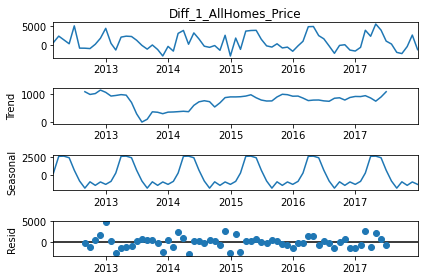

In [11]:
aux.plot();

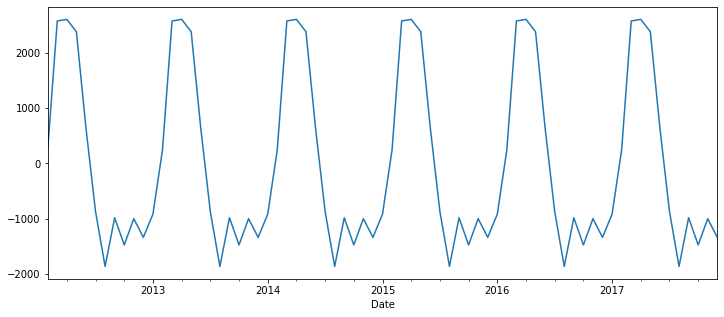

In [12]:
plt.figure(figsize = (12,5))
aux.seasonal.plot();

---

# - ARIMA

In [13]:
x = df_ts['Diff_1_AllHomes_Price']

### Correlogramas

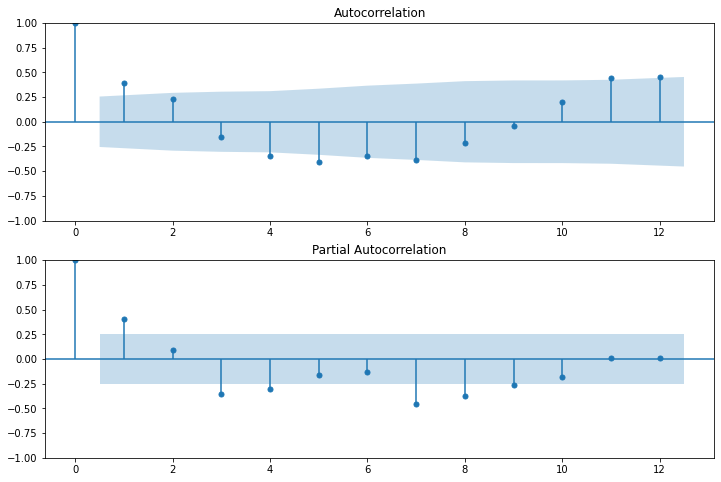

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(x.iloc[13:],lags=12,ax=ax1)
ax2 = fig.add_subplot(212)
fig = tsaplots.plot_pacf(x.iloc[13:],lags=12,ax=ax2)

### Datos: Train y Test

In [15]:
train = df_ts[0:int(len(df_ts)*.80)]
test = df_ts[int(len(df_ts)*.80):len(df_ts)]

size = len(df_aux) - 12
train, test = df_aux[0:size], df_aux[size:]

### Determinación de mejores parámetros 

In [16]:
arima_model =  auto_arima(train['MedianListingPrice_AllHomes'],start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 20 )
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1017.808, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1020.555, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1020.059, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1023.316, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1021.658, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.096 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -506.904
Date:                Mon, 05 Dec 2022   AIC                           1017.808
Time:                        02:38:13   BIC                           1021.858
Sample:                    01-31-2012   HQIC                          1019.378
                         - 09-30-2016                                       

### Entrenamiento del modelo

In [17]:
from statsmodels.tsa.arima.model import ARIMA

In [18]:
model = ARIMA(train['Diff_1_AllHomes_Price'], order=(0,1,0))
arima_fit = model.fit()

In [19]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     Diff_1_AllHomes_Price   No. Observations:                   57
Model:                    ARIMA(0, 1, 0)   Log Likelihood                -517.278
Date:                   Mon, 05 Dec 2022   AIC                           1036.556
Time:                           02:38:13   BIC                           1038.582
Sample:                       01-31-2012   HQIC                          1037.342
                            - 09-30-2016                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.981e+06    1.1e+06      5.413      0.000    3.82e+06    8.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.27   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.00   Prob(JB):                         0.94
Heteroskedasticity (H):               0.67   Skew:                             0.12
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
fc = arima_fit.forecast(len(test), alpha=0.05) 
fc_series = pd.Series(fc, index=test.index)

### Evaluación del modelo

In [21]:
MSE_arima = mean_squared_error(test['Diff_1_AllHomes_Price'], fc_series)
RMSE_arima = np.sqrt(MSE_arima)
print('MSE: ',MSE_Arima)
print('RMSE: ',RMSE_arima)

MSE:  6524923.814231637
RMSE:  2554.393042237556


In [22]:
# MAPE: Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true)*100)

In [23]:
MAPE_arima = mape(test['Diff_1_AllHomes_Price'], fc_series) 
print('MAPE: ',round(MAPE_arima,2),'%')

MAPE:  124.98 %


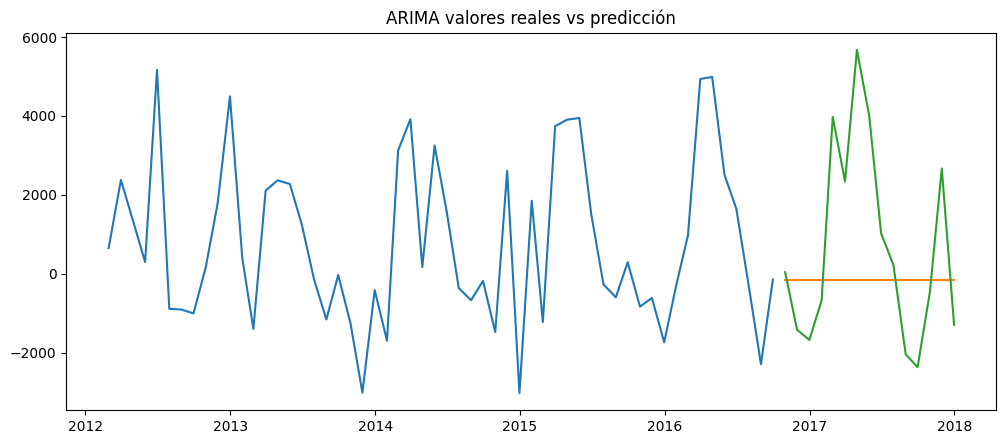

In [24]:
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Diff_1_AllHomes_Price'], label='training')
plt.plot(fc_series, label='forecast')
plt.plot(test['Diff_1_AllHomes_Price'], label='actual')


plt.title('ARIMA valores reales vs predicción')
plt.show();

### Predicción

In [25]:
# Entreno el modelo con todos los datos
model = ARIMA(df_ts['Diff_1_AllHomes_Price'], order=(0,1,0))
arima_fit = model.fit()

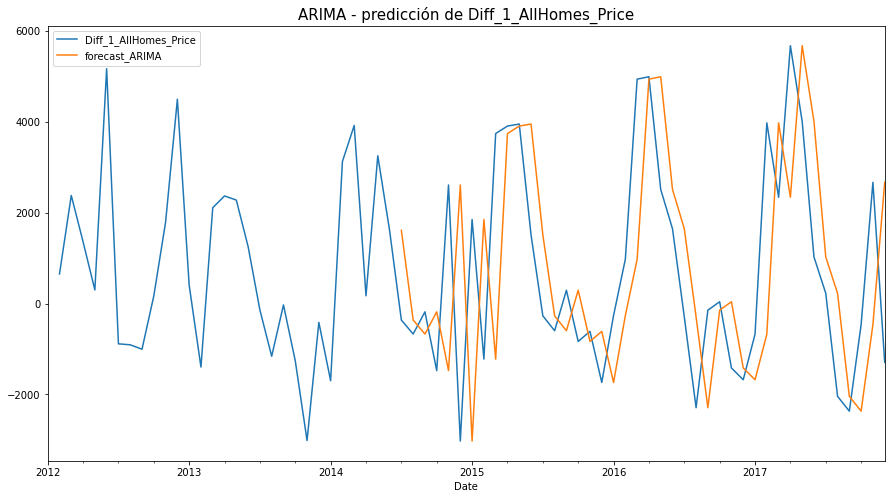

In [26]:
df_ts['forecast_ARIMA']=arima_fit.predict(start = 30, end = 156)
df_ts[['Diff_1_AllHomes_Price','forecast_ARIMA']].plot(figsize=(15,8))
plt.title('ARIMA - predicción de Diff_1_AllHomes_Price', fontsize = 15)
plt.show()

In [27]:
from pandas.tseries.offsets import DateOffset

future_arima = [df_ts.index[-1]+ DateOffset(months=x)for x in range(0,24)] # 2 años = 24 meses

In [28]:
future_df_ARIMA = pd.DataFrame(index=future_arima[1:],columns=df_ts.columns)

In [29]:
future_df = pd.concat([df_ts,future_df_ARIMA ]) # Concatenamos los dos dataframes

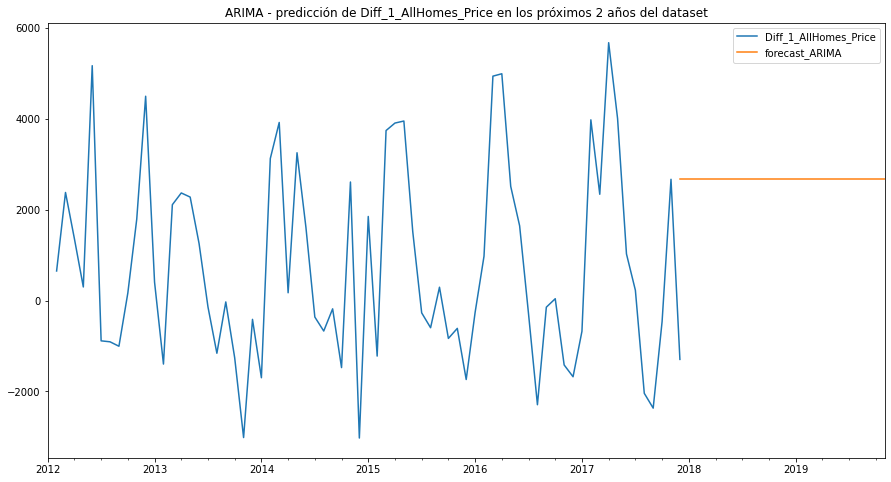

In [30]:
future_df['forecast_ARIMA'] = arima_fit.predict(start = 71, end = 156, dynamic= True)  
future_df[['Diff_1_AllHomes_Price', 'forecast_ARIMA']].plot(figsize=(15, 8)) 
plt.title('ARIMA - predicción de Diff_1_AllHomes_Price en los próximos 2 años del dataset')
plt.show()

---

## - SARIMA

### Datos: Train y Test

In [31]:
train = df_ts[0:int(len(df_ts)*.80)]
test = df_ts[int(len(df_ts)*.80):len(df_ts)]

### Determinación de mejores parámetros 

In [32]:
sarima_model =  auto_arima(train['Diff_1_AllHomes_Price'].dropna(),start_p=0, d=1, start_q=0, 
                          max_p=6, max_d=6, max_q=6, start_P=0, 
                          D=1, start_Q=0, max_P=6, max_D=6,
                          max_Q=6, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 20 )
print(sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=822.997, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=786.629, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=809.891, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=787.577, Time=0.29 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=787.578, Time=0.17 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=789.562, Time=0.43 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=806.473, Time=0.04 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=785.675, Time=0.12 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=809.543, Time=0.02 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=787.433, Time=0.31 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=787.460, Time=0.22 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=789.221, Time=0.15 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AI

### Entrenamiento del modelo

In [33]:
sarima_model = SARIMAX(train['Diff_1_AllHomes_Price'], order=(2,1,0),seasonal_order=(1,1,0,12))
sarima_fit = sarima_model.fit(disp=1)

In [34]:
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:              Diff_1_AllHomes_Price   No. Observations:                   57
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -399.385
Date:                            Mon, 05 Dec 2022   AIC                            806.769
Time:                                    02:38:18   BIC                            813.906
Sample:                                01-31-2012   HQIC                           809.416
                                     - 09-30-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7415      0.155     -4.794      0.000      -1.045      -0.438
ar.L2         -0.2495      0.191     -1.305      0.192      -0.624       0.125
ar.S.L12      -0.6626      0.101     -6.537      0.000      -0.861      -0.464
sigma2      4.365e+06   8.09e+05      5.396      0.000    2.78e+06    5.95e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.44   Prob(JB):                         0.35
Heteroskedasticity (H):               0.31   Skew:                            -0.17
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Evaluación del modelo

In [35]:
sarima_fc_series = sarima_fit.forecast(len(test), alpha=0.05) 
MSE_sarima = mean_squared_error(test['Diff_1_AllHomes_Price'], sarima_fc_series)
RMSE_sarima = np.sqrt(MSE_sarima)

print('MSE:', MSE_sarima)
print('RMSE:', RMSE_sarima)

MSE: 4528284.691534837
RMSE: 2127.9766661161575


In [36]:
mape_sarima = mape(test['Diff_1_AllHomes_Price'], sarima_fc_series) 
print('MAPE: ',round(mape_sarima,2),'%')

MAPE:  483.3 %


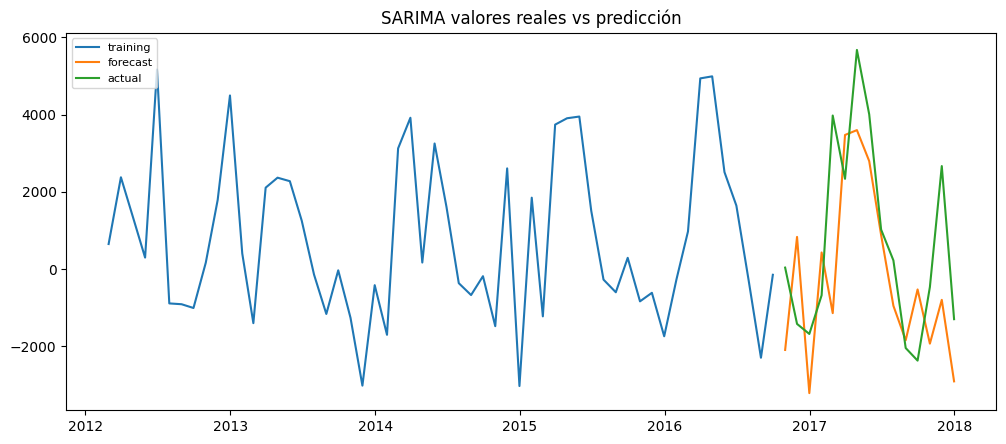

In [37]:
sarima_fc_series = pd.Series(sarima_fc_series, index=test.index)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Diff_1_AllHomes_Price'], label='training')
plt.plot(sarima_fc_series, label='forecast')
plt.plot(test['Diff_1_AllHomes_Price'], label='actual')


plt.title('SARIMA valores reales vs predicción')
plt.legend(loc='upper left', fontsize=8);

### Predicción

In [38]:
sarima_model = sm.tsa.statespace.sarimax.SARIMAX(df_ts['Diff_1_AllHomes_Price'], order=(2,1,0),seasonal_order=(1,1,0,12))
sarima_fit = sarima_model.fit(disp=0)

In [39]:
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:              Diff_1_AllHomes_Price   No. Observations:                   72
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -536.685
Date:                            Mon, 05 Dec 2022   AIC                           1081.369
Time:                                    02:38:18   BIC                           1089.679
Sample:                                01-31-2012   HQIC                          1084.613
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7848      0.144     -5.465      0.000      -1.066      -0.503
ar.L2         -0.2628      0.171     -1.538      0.124      -0.598       0.072
ar.S.L12      -0.6038      0.099     -6.105      0.000      -0.798      -0.410
sigma2      4.606e+06   7.27e+05      6.335      0.000    3.18e+06    6.03e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):                 2.89
Prob(Q):                              0.42   Prob(JB):                         0.24
Heteroskedasticity (H):               0.79   Skew:                             0.26
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

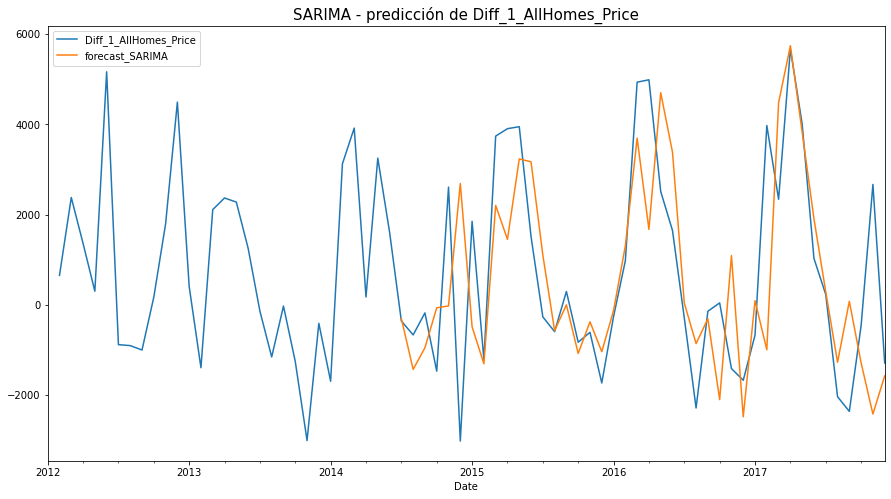

In [40]:
df_ts['forecast_SARIMA']=sarima_fit.predict(start = 30, end = 156)
df_ts[['Diff_1_AllHomes_Price','forecast_SARIMA']].plot(figsize=(15,8))
plt.title('SARIMA - predicción de Diff_1_AllHomes_Price', fontsize = 15)
plt.show()

In [41]:
from pandas.tseries.offsets import DateOffset

future_sarima = [df_ts.index[-1]+ DateOffset(months=x)for x in range(0,24)] # 2 años = 24 meses

In [42]:
future_df_SARIMA = pd.DataFrame(index=future_sarima[1:],columns=df_ts.columns)

In [43]:
future_df_SARIMA  = pd.concat([df_ts,future_df_SARIMA]) # Concatenamos los dos dataframes

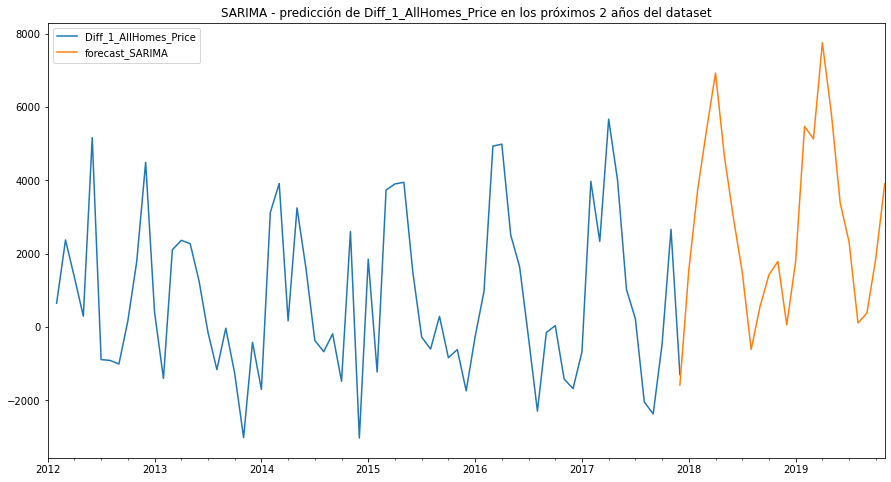

In [44]:
future_df_SARIMA ['forecast_SARIMA'] = sarima_fit.predict(start = 71, end = 156)  
future_df_SARIMA [['Diff_1_AllHomes_Price', 'forecast_SARIMA']].plot(figsize=(15, 8)) 
plt.title('SARIMA - predicción de Diff_1_AllHomes_Price en los próximos 2 años del dataset')
plt.show()

---

# PROPHET

In [45]:
ts_aux = df_ts
ts_aux = ts_aux.reset_index()

In [46]:
train = ts_aux[0:int(len(ts_aux)*.80)]
test = ts_aux[int(len(ts_aux)*.80):len(ts_aux)]

In [47]:
data_month = data_drop.resample('M',on='Date').mean()
df_aux_prophet = data_month.reset_index()
date = data_month.reset_index()
df_ts_prophet = df_aux_prophet
df_ts_prophet.set_index(['Date'],inplace = True)
df_ts_prophet['Diff_1_AllHomes_Price'] = df_ts_prophet['MedianListingPrice_AllHomes'].diff()
df_ts_prophet = df_ts_prophet.reset_index()
df_ts_prophet.head()

,Date,MedianListingPrice_AllHomes,Sale_Prices,Sale_Counts,Diff_1_AllHomes_Price
0,2012-01-31,186217.29,170674.0,4143.204082,NaN
1,2012-02-29,186866.94,169831.0,4202.816327,649.65
2,2012-03-31,189243.83,170393.0,4706.687500,2376.89
3,2012-04-30,190602.20,171191.0,4788.916667,1358.37
4,2012-05-31,190900.50,171174.0,5135.531915,298.30


In [48]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [49]:
# Prophet trabaja la columna Date con el nombre 'ds' y la columna con las etiquetas con el nombre 'y'
df_ts_prophet = df_ts_prophet.drop(columns= ['Sale_Prices', 'Sale_Counts', 'MedianListingPrice_AllHomes'])
df_ts_prophet.reset_index(level= 0, inplace= True)
df_ts_prophet.rename(columns= {'Date': 'ds', 'Diff_1_AllHomes_Price' : 'y'}, inplace = True)

### Entrenamiento del modelo

In [50]:
# Instanciamos un modelo de Prophet

prophet = Prophet(yearly_seasonality= True, uncertainty_samples = 50, mcmc_samples=50, interval_width= 0.6)

# Entrenamos el modelo
prophet.fit(df_ts_prophet)

# Construimos un dataframe con los x valores futuros que querámos predecir. En este caso, 2 años.
future = prophet.make_future_dataframe(periods=(2*12), freq='M')

# Predecimos
forecast_prophet = prophet.predict(future)

02:38:19 - cmdstanpy - INFO - CmdStan installation c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
02:38:19 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
02:38:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██████████| 00:00 Iteration:  1 / 50 [  2%]  (Warmup)

chain 1 |██████████| 00:00 Sampling completed                 
chain 2 |██████████| 00:00 Sampling completed                 
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                 


02:38:20 - cmdstanpy - INFO - CmdStan done processing.
02:38:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:38:20 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 21 itera

### - PREDICCIÓN

In [51]:
# yhat: valor pronosticado , (yhat_lower, yhat_upper): valores entre los que varia la prediccion, 
prophet_pred = prophet.predict(future)
prophet_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-31,746.370712,-1130.830365,2680.702142,299.868804,1187.878247,-84.970250,-1008.287633,1005.428796,-84.970250,-1008.287633,1005.428796,0.0,0.0,0.0,661.400462
1,2012-02-29,753.177344,-338.792426,2522.316953,304.480083,1198.610567,321.354529,-408.468574,1039.071312,321.354529,-408.468574,1039.071312,0.0,0.0,0.0,1074.531873
2,2012-03-31,760.453400,1652.792350,4684.807418,314.264677,1196.203137,2280.366141,1330.916037,3068.010120,2280.366141,1330.916037,3068.010120,0.0,0.0,0.0,3040.819541
3,2012-04-30,767.494744,769.859254,4154.537524,323.425351,1218.649484,2052.295132,1247.603698,2789.474765,2052.295132,1247.603698,2789.474765,0.0,0.0,0.0,2819.789876
4,2012-05-31,774.886739,-251.450307,3889.990517,357.083026,1201.881407,882.742775,-95.065655,2000.784391,882.742775,-95.065655,2000.784391,0.0,0.0,0.0,1657.629514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2019-08-31,1185.146026,-2559.797217,763.015128,572.883987,1758.367393,-2073.279831,-2918.475883,-1362.561886,-2073.279831,-2918.475883,-1362.561886,0.0,0.0,0.0,-888.133805
92,2019-09-30,1188.617302,-2644.713536,2144.138036,575.614052,1777.732145,-1129.005107,-2250.058579,284.055251,-1129.005107,-2250.058579,284.055251,0.0,0.0,0.0,59.612195
93,2019-10-31,1192.204287,-2247.186384,1210.121231,575.179103,1782.177087,-1656.525205,-2806.968852,-545.498925,-1656.525205,-2806.968852,-545.498925,0.0,0.0,0.0,-464.320918
94,2019-11-30,1195.675562,-1202.223613,2604.157426,559.849409,1796.974439,-8.265368,-1179.106205,1217.978754,-8.265368,-1179.106205,1217.978754,0.0,0.0,0.0,1187.410194


In [52]:
df_aux_prophet = df_aux_prophet.reset_index()

In [53]:
df_aux_prophet

,Date,MedianListingPrice_AllHomes,Sale_Prices,Sale_Counts,Diff_1_AllHomes_Price
0,2012-01-31,186217.290000,170674.000000,4143.204082,NaN
1,2012-02-29,186866.940000,169831.000000,4202.816327,649.650000
2,2012-03-31,189243.830000,170393.000000,4706.687500,2376.890000
3,2012-04-30,190602.200000,171191.000000,4788.916667,1358.370000
4,2012-05-31,190900.500000,171174.000000,5135.531915,298.300000
...,...,...,...,...,...
67,2017-08-31,241460.319149,198148.913043,7070.227273,-2041.446809
68,2017-09-30,239093.097826,199333.695652,7176.604167,-2367.221323
69,2017-10-31,238629.880435,200748.913043,7127.458333,-463.217391
70,2017-11-30,241296.595745,195058.888889,5730.333333,2666.715310


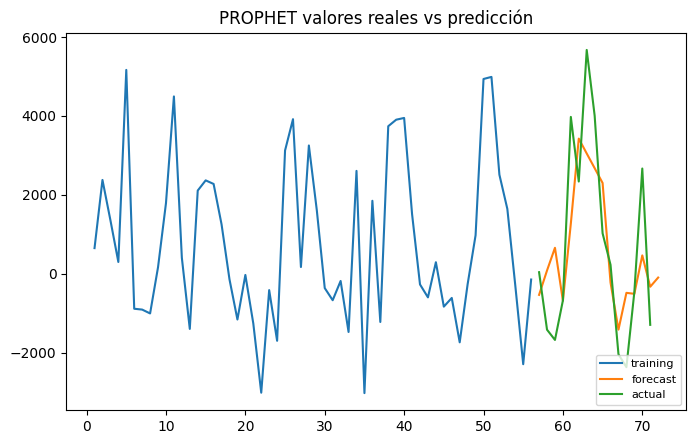

In [54]:
# Plot
plt.figure(figsize=(8,5), dpi=100)
plt.plot(train['Diff_1_AllHomes_Price'], label='training')
plt.plot(prophet_pred.yhat[57:73], label='forecast')
plt.plot(test['Diff_1_AllHomes_Price'], label='actual')


plt.title('PROPHET valores reales vs predicción')
plt.legend(loc='lower right', fontsize=8)
plt.show();

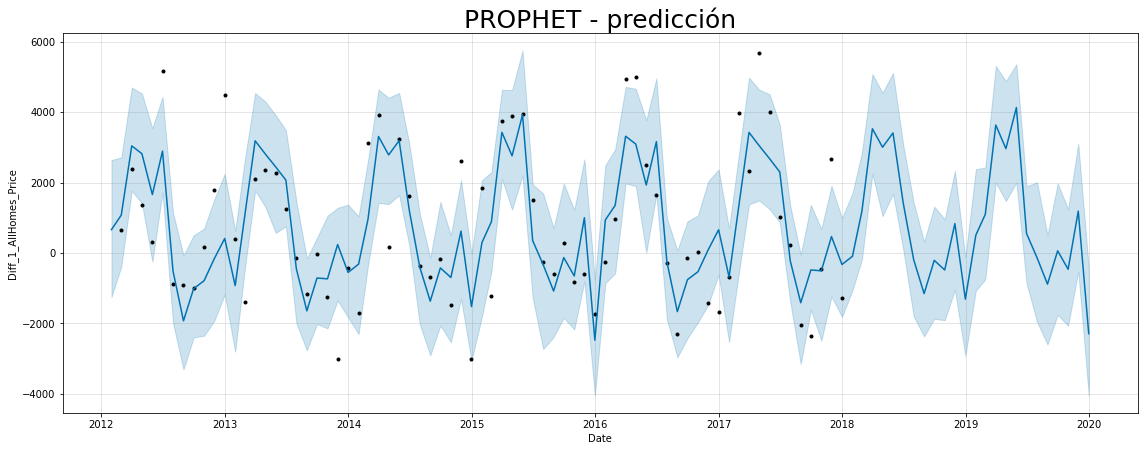

In [55]:
# plot forecasts

prophet.plot(forecast_prophet, xlabel='Date', ylabel='Diff_1_AllHomes_Price', figsize = (16,6))
plt.title('PROPHET - predicción', fontsize = 25)
plt.show()

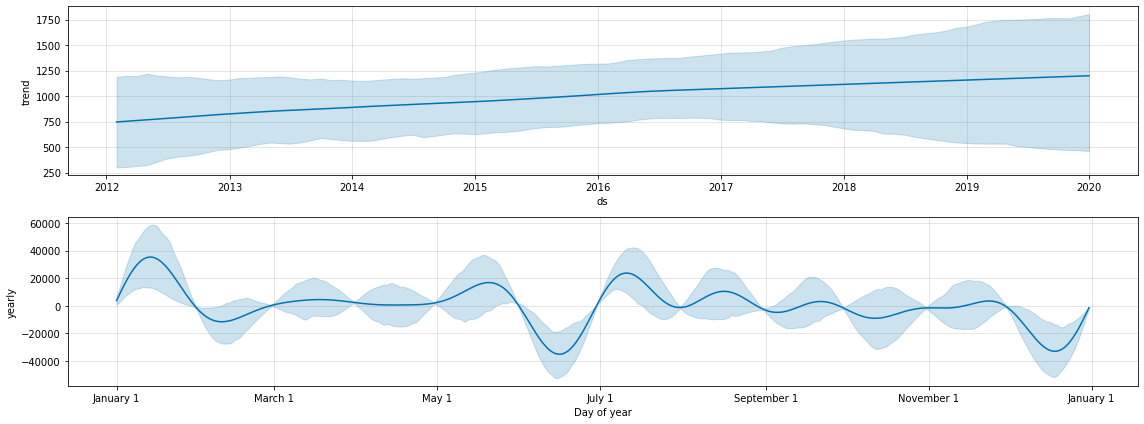

In [56]:
# Ploteamos los componentes de nuestra serie de tiempo

components = prophet.plot_components(forecast_prophet, figsize=(16,6))

### - Evaluación del modelo

In [57]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [58]:
df_cv = cross_validation(model=prophet, horizon= '365 days')

  0%|          | 0/4 [00:00<?, ?it/s]02:38:21 - cmdstanpy - INFO - CmdStan installation c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
02:38:21 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
02:38:21 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed                 
chain 2 |██████████| 00:00 Sampling completed                 
chain 3 |██████████| 00:00 Sampling completed                 
chain 4 |██████████| 00:00 Sampling completed                 


02:38:21 - cmdstanpy - INFO - CmdStan done processing.
02:38:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:38:21 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 iterations at max treedepth (32.0%)
	Chain 2 had 16 iterations at max treedepth (64.0%)
	Chain 3 had 18 iterations at max treedepth (72.0%)
	Chain 4 had 13 iterations at max treede

02:38:22 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
02:38:22 - cmdstanpy - INFO - CmdStan start processing
















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                 
chain 4 |██████████| 00:00 Sampling completed                   


02:38:22 - cmdstanpy - INFO - CmdStan done processing.
02:38:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:38:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 20 iterations at max treedepth (80.0%)
	Chain 2 had 19 iterations at max treedepth (76.0%)
	Chain 3 had 15 iterations at max treedepth (60.0%)
	Chain 4 had 22 iterations at max tre

02:38:22 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
02:38:22 - cmdstanpy - INFO - CmdStan start processing
















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                 
chain 4 |██████████| 00:00 Sampling completed                   


02:38:23 - cmdstanpy - INFO - CmdStan done processing.
02:38:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:38:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 20 iterations at max treedepth (80.0%)
	Chain 2 had 20 iterations at max treedepth (80.0%)
	Chain 3 had 20 iterations at max treedepth (80.0%)
	Chain 4 had 16 iterations at max tre

02:38:23 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
02:38:23 - cmdstanpy - INFO - CmdStan start processing

















chain 1 |██████████| 00:00 Sampling completed                 
chain 2 |██████████| 00:00 Sampling completed                 
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   


02:38:23 - cmdstanpy - INFO - CmdStan done processing.
02:38:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:38:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 17 iterations at max treedepth (68.0%)
	Chain 2 had 15 iterations at max treedepth (60.0%)
	Chain 3 had 15 iterations at max treedepth (60.0%)
	Chain 4 had 16 iterations at max t

In [59]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-07-31,-351.984040,-2752.460987,1492.475711,-271.343750,2015-07-02 12:00:00
1,2015-08-31,-1014.347278,-4075.112660,1794.548768,-598.604167,2015-07-02 12:00:00
2,2015-09-30,629.731578,-1003.484931,2619.834033,292.687500,2015-07-02 12:00:00
3,2015-10-31,616.118557,-1569.761738,2256.002662,-833.520833,2015-07-02 12:00:00
4,2015-11-30,2086.419111,-230.850221,4602.839011,-612.885417,2015-07-02 12:00:00
5,2015-12-31,-4018.240381,-6146.715154,-1342.315640,-1737.468750,2015-07-02 12:00:00
6,2016-01-31,2591.395178,186.611498,5317.094649,-263.208333,2015-07-02 12:00:00
7,2016-02-29,713.356607,-1042.136434,2769.245509,975.000000,2015-07-02 12:00:00
8,2016-03-31,3251.322685,1161.396815,4948.389439,4935.770833,2015-07-02 12:00:00
9,2016-04-30,2253.668507,622.142526,4051.923844,4988.510417,2015-07-02 12:00:00


In [60]:
df_p = performance_metrics(df_cv)
df_p.describe()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,29,2.900000e+01,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,190 days 00:24:49.655172414,3.942696e+06,1931.351983,1655.444814,2.712538,1.103666,1.113477,0.590517
std,98 days 21:28:33.220873082,1.765773e+06,469.220418,469.597778,2.362550,0.685858,0.352619,0.182666
min,31 days 00:00:00,1.099846e+06,1048.735587,881.654600,0.485429,0.387176,0.545433,0.250000
25%,120 days 00:00:00,2.744407e+06,1656.625036,1318.352824,1.074615,0.598602,0.821033,0.500000
50%,181 days 12:00:00,3.626933e+06,1904.450739,1709.238010,1.643340,0.803654,1.082806,0.500000
75%,272 days 12:00:00,5.305477e+06,2303.362067,2039.702450,3.207622,1.353734,1.307232,0.750000
max,365 days 00:00:00,7.366029e+06,2714.042983,2530.188295,8.043809,3.071716,2.000000,1.000000


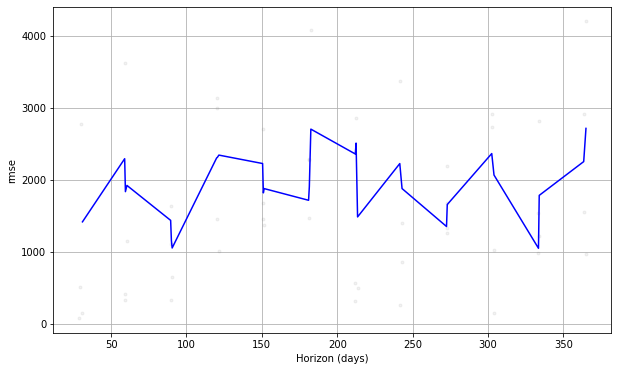

In [61]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [62]:
print('El RMSE es:', df_p.rmse.mean())

El RMSE es: 1931.3519826009638


In [63]:
df_p = performance_metrics(df_cv, rolling_window = 1)

In [64]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,365 days,3.868956e+06,1966.966185,1631.23007,2.654322,0.851452,1.105343,0.604167


---

# LSTM

In [65]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [82]:
df_LSTM = pd.DataFrame(df_ts['Diff_1_AllHomes_Price'].dropna())
df_LSTM

,Diff_1_AllHomes_Price
Date,
2012-02-29,649.650000
2012-03-31,2376.890000
2012-04-30,1358.370000
2012-05-31,298.300000
2012-06-30,5166.068627
...,...
2017-08-31,-2041.446809
2017-09-30,-2367.221323
2017-10-31,-463.217391


In [83]:
size = int(len(df_LSTM) * 0.8)

train_LSTM, test_LSTM = df_LSTM[0:size], df_LSTM[size:len(df_LSTM)]

In [84]:
# Escalar los datos a un rango entre (-1,1) para favorecer el proceso de cálculo de la red neuronal
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_LSTM)
scaled_train_data = scaler.transform(train_LSTM)
scaled_test_data = scaler.transform(test_LSTM)

In [85]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [86]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(100, input_shape=(n_input, n_features)))
LSTM_model.add(Dense(1))
LSTM_model.compile(loss='mse', optimizer='adam')
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [87]:
LSTM_model.fit_generator(generator,epochs=200)

Epoch 1/200
44/44 [==============================] - 1s 3ms/step - loss: 0.2549
Epoch 2/200
44/44 [==============================] - 0s 2ms/step - loss: 0.2104
Epoch 3/200
44/44 [==============================] - 0s 3ms/step - loss: 0.1833
Epoch 4/200
44/44 [==============================] - 0s 2ms/step - loss: 0.1645
Epoch 5/200
44/44 [==============================] - 0s 3ms/step - loss: 0.1725
Epoch 6/200
44/44 [==============================] - 0s 2ms/step - loss: 0.1718
Epoch 7/200
44/44 [==============================] - 0s 3ms/step - loss: 0.1639
Epoch 8/200
44/44 [==============================] - 0s 2ms/step - loss: 0.1554
Epoch 9/200
44/44 [==============================] - 0s 2ms/step - loss: 0.1693
Epoch 10/200
44/44 [==============================] - 0s 2ms/step - loss: 0.1657
Epoch 11/200
44/44 [==============================] - 0s 2ms/step - loss: 0.1706
Epoch 12/200
44/44 [==============================] - 0s 3ms/step - loss: 0.1693
Epoch 13/200
44/44 [=================

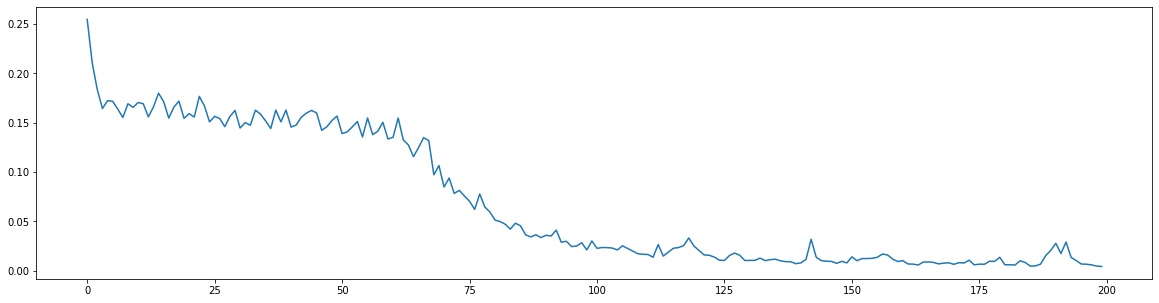

In [88]:
perdida_LSTM = LSTM_model.history.history['loss']
plt.figure(figsize=(20,5))
plt.xticks()
plt.plot(range(len(perdida_LSTM)),perdida_LSTM);

In [89]:
LSTM_prediccion_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test)):   
    LSTM_pred = LSTM_model.predict(current_batch)[0]
    LSTM_prediccion_scaled.append(LSTM_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[LSTM_pred]],axis=1)

1/1 [==============================] - 0s 14ms/step


In [90]:
LSTM_prediccion = scaler.inverse_transform(LSTM_prediccion_scaled)

In [91]:
MSE_LSTM = mean_squared_error(test_LSTM, LSTM_prediccion)
RMSE_LSTM = np.sqrt(MSE_LSTM)

print('MSE:', MSE_LSTM)
print('RMSE:', RMSE_LSTM)

MSE: 3704412.9384340886
RMSE: 1924.6851530663628


In [92]:
mape_LSTM = mape(test_LSTM, LSTM_prediccion) 
print('MAPE: ',round(mape_LSTM,2),'%')

MAPE:  Diff_1_AllHomes_Price    388.86
dtype: float64 %


In [93]:
index_date_test = df_ts.tail(15).index

In [94]:
df_pred_LSTM = pd.DataFrame(LSTM_prediccion, index= index_date_test)

In [95]:
df_pred_LSTM.rename(columns = {0:'LSTM_pred'}, inplace=True)

In [96]:
df_pred_LSTM

,LSTM_pred
Date,
2016-10-31,1348.764502
2016-11-30,-1085.107467
2016-12-31,-477.568442
2017-01-31,659.426428
2017-02-28,3709.641630
2017-03-31,5081.771013
2017-04-30,3438.232267
2017-05-31,2305.558852
2017-06-30,-203.911646


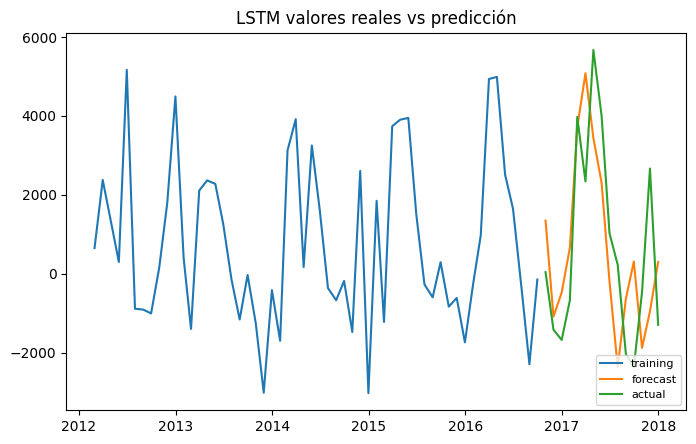

In [97]:
# Plot
plt.figure(figsize=(8,5), dpi=100)

plt.plot(train_LSTM, label='training')
plt.plot(df_pred_LSTM, label='forecast')
plt.plot(test_LSTM, label='actual')
plt.title('LSTM valores reales vs predicción')
plt.legend(loc='lower right', fontsize=8)
plt.show();

---

# - CONCLUSIÓN

- Al analizar los resultados de las métricas de evaluación y las gráficas de predicción se determina que el modelo Prophet es el que mejor ajusta a nuestro problema.